In [1]:
from numpy.random import seed
seed(42)

import tensorflow as tf
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [3]:
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import math
import pandas as pd

#from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_objective_2D #, plot_histogram
from skopt.utils import use_named_args

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
def log_dir_name(
    learning_rate,
    hidden_layers,
    neurons_per_layer,
    dropout_rate,
    l2_lambda,
    class_0_weight,
    class_1_weight
):

    # The dir-name for the TensorBoard log-dir.
    s = "./MLP_logs/hidden_layers{0}_neurons_per_layer{1}/"

    # Insert all the hyper-parameters in the dir-name.
    log_dir = s.format(
        learning_rate,
        hidden_layers,
        neurons_per_layer,
        dropout_rate,
        l2_lambda,
        class_0_weight,
        class_1_weight
    )

    return log_dir


def plot_metrics(history):
    metrics =  ['loss', 'auc', 'f1']
    
    plt.subplots(1,4,figsize=(14,5))
    
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(1,3,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        
    if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
        
    elif metric == 'auc':
        plt.ylim([0.8,1])
        
    else:
        #plt.ylim([0,1])
        plt.legend()
        
    plt.tight_layout()
    plt.savefig('../figures/simple_MLP_learning_curves.png', bbox_inches='tight')
        
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    normalized_cm = np.empty([2, 2])
    normalized_cm[0][0] = cm[0][0] / (cm[0][0] + cm[0][1])
    normalized_cm[0][1] = cm[0][1] / (cm[0][0] + cm[0][1])
    normalized_cm[1][0] = cm[1][0] / (cm[1][0] + cm[1][1])
    normalized_cm[1][1] = cm[1][1] / (cm[1][0] + cm[1][1])
    plt.figure(figsize=(5,5))
    sns.heatmap(normalized_cm, annot=True)
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('No fire (True Negatives): ', cm[0][0])
    print('False alarms (False Positives): ', cm[0][1])
    print('Fires missed (False Negatives): ', cm[1][0])
    print('Fires detected (True Positives): ', cm[1][1])
    print('Total fires: ', np.sum(cm[1]))
    
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    #plt.xlim([-0.5,20])
    #plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    
def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    
    return f1_val

In [7]:
data_file = '../data/stratified_training_data/1992-2015_training_data_added_features_n500000_ks_pval0.3.1.csv'
validation_file = '../data/stratified_training_data/1992-2015_training_data_added_features_n500000_ks_pval0.3.2.csv'
test_file = '../data/stratified_training_data/1992-2015_training_data_added_features_n500000_ks_pval0.3.3.csv'

# Datatypes for dataframe loading
dtypes = {
    'lat': float,
    'lon': float,
    'weather_bin_year': int,
    'weather_bin_month': int,
    'weather_bin_day': int,
    'air.2m': float,
    'apcp': float,
    'rhum.2m': float,
    'dpt.2m': float,
    'pres.sfc': float,
    'uwnd.10m': float,
    'vwnd.10m': float,
    'veg': float,
    'vis': float,
    'ignition': float,
    'mean.air.2m': float,
    'mean.apcp': float,
    'mean.rhum.2m': float,
    'mean.dpt.2m': float,
    'mean.pres.sfc': float,
    'mean.uwnd.10m': float,
    'mean.vwnd.10m': float,
    'mean.veg': float,
    'mean.vis': float,
    'max.air.2m': float,
    'max.apcp': float,
    'max.rhum.2m': float,
    'max.dpt.2m': float,
    'max.pres.sfc': float,
    'max.uwnd.10m': float,
    'max.vwnd.10m': float,
    'max.veg': float,
    'max.vis': float,
    'min.air.2m': float,
    'min.apcp': float,
    'min.rhum.2m': float,
    'min.dpt.2m': float,
    'min.pres.sfc': float,
    'min.uwnd.10m': float,
    'min.vwnd.10m': float,
    'min.veg': float,
    'min.vis': float,
    'total_fires': float

}

# Features to use during training 
features = [
    'lat',
    'lon',
    'weather_bin_month',
    'veg',
    'ignition',
    'mean.air.2m',
    'mean.apcp',
    'mean.rhum.2m',
    'mean.dpt.2m',
    'mean.pres.sfc',
    'mean.uwnd.10m',
    'mean.vwnd.10m',
    'mean.vis',
    'max.air.2m',
    'max.apcp',
    'max.rhum.2m',
    'max.dpt.2m',
    'max.pres.sfc',
    'max.uwnd.10m',
    'max.vwnd.10m',
    'max.vis',
    'min.air.2m',
    'min.apcp',
    'min.rhum.2m',
    'min.dpt.2m',
    'min.pres.sfc',
    'min.uwnd.10m',
    'min.vwnd.10m',
    'min.vis',
    'total_fires'
]

features_to_scale = [
    'lat',
    'lon',
    'veg',
    'mean.air.2m',
    'mean.apcp',
    'mean.rhum.2m',
    'mean.dpt.2m',
    'mean.pres.sfc',
    'mean.uwnd.10m',
    'mean.vwnd.10m',
    'mean.vis',
    'max.air.2m',
    'max.apcp',
    'max.rhum.2m',
    'max.dpt.2m',
    'max.pres.sfc',
    'max.uwnd.10m',
    'max.vwnd.10m',
    'max.vis',
    'min.air.2m',
    'min.apcp',
    'min.rhum.2m',
    'min.dpt.2m',
    'min.pres.sfc',
    'min.uwnd.10m',
    'min.vwnd.10m',
    'min.vis',
    'total_fires'
]

metrics = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    f1
]

dim_learning_rate = Real(
    low=1e-5, 
    high=1e-1, 
    prior='log-uniform',
    name='learning_rate'
)

dim_hidden_layers = Integer(
    low=5,
    high=15, 
    name='hidden_layers'
)

dim_neurons_per_layer = Integer(
    low=10, 
    high=100, 
    name='neurons_per_layer'
)

dim_dropout_rate = Real(
    low=0.1, 
    high=0.5, 
    name='dropout_rate'
)

dim_l2_lambda = Real(
    low=0.001, 
    high=0.1, 
    name='l2_lambda'
)

dim_class_0_weight = Real(
    low=0.1,
    high=5,
    name='class_0_weight'
)

dim_class_1_weight = Real(
    low=10,
    high=15,
    name="class_1_weight"
)

dimensions = [
    dim_learning_rate,
    dim_hidden_layers,
    dim_neurons_per_layer,
    dim_dropout_rate,
    dim_l2_lambda,
    dim_class_0_weight,
    dim_class_1_weight
]

default_parameters = [0.001, 10, 50, 0.25, 0.05, 0.5, 12]

path_best_model = '../trained_models/best_skopt_MLP.keras'
best_fraction_incorrect = 1.0

In [8]:
data = pd.read_csv(data_file, dtype=dtypes)
validation = pd.read_csv(validation_file, dtype=dtypes)

In [9]:
# Pull out columns of intrest
training_data = data[features]
validation_data = validation[features]

In [10]:
# One hot encode month

column_names = [
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'Septermber',
    'October',
    'November',
    'December'
]


onehot_encoder = OneHotEncoder(sparse=False)

# Training data
month = np.array(training_data['weather_bin_month']).reshape(-1, 1)
onehot_month = onehot_encoder.fit_transform(month)

training_data.drop('weather_bin_month', axis=1, inplace=True)
onehot_month_df = pd.DataFrame(onehot_month, columns=column_names)
training_data = pd.concat([training_data, onehot_month_df], axis=1)

# Validation data
month = np.array(validation_data['weather_bin_month']).reshape(-1, 1)
onehot_month = onehot_encoder.fit_transform(month)

validation_data.drop('weather_bin_month', axis=1, inplace=True)
onehot_month_df = pd.DataFrame(onehot_month, columns=column_names)
validation_data = pd.concat([validation_data, onehot_month_df], axis=1)

/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

In [11]:
training_data.head()

,lat,lon,veg,ignition,mean.air.2m,mean.apcp,mean.rhum.2m,mean.dpt.2m,mean.pres.sfc,mean.uwnd.10m,...,March,April,May,June,July,August,Septermber,October,November,December
0,34.18678,-118.8088,25.5,0.0,289.170681,0.000000,57.576653,279.735122,96650.870000,0.064065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,37.03086,-119.0176,43.3,0.0,294.386004,0.000122,33.640771,277.393281,79824.146797,-0.407725,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,37.49919,-119.8433,33.9,0.0,287.263178,0.139648,60.458148,279.509951,89032.984219,-0.223786,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,36.23206,-118.5007,46.9,0.0,267.102028,0.000318,45.363947,256.344916,76906.623375,0.438386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,32.91990,-114.8649,3.5,0.0,289.117580,0.000506,26.899587,269.320998,99661.673406,1.417608,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [12]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449258 entries, 0 to 449257
Data columns (total 41 columns):
lat              449258 non-null float64
lon              449258 non-null float64
veg              449258 non-null float64
ignition         449258 non-null float64
mean.air.2m      449258 non-null float64
mean.apcp        449258 non-null float64
mean.rhum.2m     449258 non-null float64
mean.dpt.2m      449258 non-null float64
mean.pres.sfc    449258 non-null float64
mean.uwnd.10m    449258 non-null float64
mean.vwnd.10m    449258 non-null float64
mean.vis         449258 non-null float64
max.air.2m       449258 non-null float64
max.apcp         449258 non-null float64
max.rhum.2m      449258 non-null float64
max.dpt.2m       449258 non-null float64
max.pres.sfc     449258 non-null float64
max.uwnd.10m     449258 non-null float64
max.vwnd.10m     449258 non-null float64
max.vis          449258 non-null float64
min.air.2m       449258 non-null float64
min.apcp         449258 non-

In [13]:
# Form np arrays of labels and features.
train_labels = np.array(training_data.pop('ignition'))
#bool_train_labels = train_labels != 0
val_labels = np.array(validation_data.pop('ignition'))

train_features = np.array(training_data)
val_features = np.array(validation_data)

In [14]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)

Training labels shape: (449258,)
Validation labels shape: (449257,)
Test labels shape: (449258,)
Training features shape: (449258, 40)
Validation features shape: (449257, 40)
Test features shape: (449258, 40)


In [15]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
# weight_for_0 = (1 / no_ignition_count)*(total)/2.0 
# weight_for_1 = (1 / ignition_count)*(total)/2.0

# class_weight = {0: weight_for_0, 1: weight_for_1}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))

ignition_count = sum(train_labels)
no_ignition_count = len(train_labels) - ignition_count

initial_bias = np.log([ignition_count/no_ignition_count])
output_bias = tf.keras.initializers.Constant(initial_bias)

EPOCHS = 20
BATCH_SIZE = 1000
STEPS_PER_EPOCH = (len(train_features) * 0.2) // BATCH_SIZE
VALIDATION_STEPS = (len(val_features) * 0.2) // BATCH_SIZE

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [16]:
def make_model(
    output_bias,
    learning_rate,
    hidden_layers,
    neurons_per_layer,
    dropout_rate,
    l2_lambda
):    
    # Define the keras model
    model = keras.Sequential()
    
    # Add input layer
    model.add(keras.layers.Dense(
        neurons_per_layer, 
        activation = 'relu', 
        input_dim = train_features.shape[-1],
    ))

    # Add fully connected hidden layers
    for i in range(hidden_layers):
        model.add(keras.layers.Dense(
            neurons_per_layer,
            bias_initializer=keras.initializers.VarianceScaling(
                scale=1.0,
                mode='fan_in', 
                distribution='normal', 
                seed=None
            ),
            kernel_regularizer=keras.regularizers.l2(l2_lambda),
            activation = 'relu')
        )
    
    # Add dropout layer
    model.add(keras.layers.Dropout(dropout_rate))
    
    # Add output layer
    model.add(keras.layers.Dense(
        1, 
        activation = 'sigmoid', 
        bias_initializer = output_bias
    ))

    model.compile(
        optimizer=keras.optimizers.Adam(lr=learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )

    return model


@use_named_args(dimensions=dimensions)
def fitness(
    learning_rate,
    hidden_layers,
    neurons_per_layer,
    dropout_rate,
    l2_lambda,
    class_0_weight,
    class_1_weight
):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    class_weight = {0: class_0_weight, 1: class_1_weight}
    
    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('hidden layers:', hidden_layers)
    print('neurons per layer:', neurons_per_layer)
    print('dropout rate: {}'.format(np.round(dropout_rate,2)))
    print('l2 lambda: {0:.1e}'.format(l2_lambda))
    print('class weight: {}, {}'.format(np.round(class_weight[0],1), np.round(class_weight[1],2)))
    print()
    
    # Create the neural network with these hyper-parameters.
    model = make_model(
        output_bias,
        learning_rate = learning_rate,
        hidden_layers = hidden_layers,
        neurons_per_layer = neurons_per_layer,
        dropout_rate = dropout_rate,
        l2_lambda = l2_lambda
    )
    
    model.summary()
    print()

    # Dir-name for the TensorBoard log-files.
    log_dir = log_dir_name(
        learning_rate,
        hidden_layers,
        neurons_per_layer,
        dropout_rate,
        l2_lambda,
        class_0_weight,
        class_1_weight
    )
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    callback_log = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True,
        write_grads=False,
        write_images=False
    )
   
    # Use Keras to train the model.
    history = model.fit(
        train_features,
        train_labels,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks = [early_stopping],
        validation_data=(val_features, val_labels),
        validation_steps=VALIDATION_STEPS,
        class_weight=class_weight,
        workers=8
    )

    # Get fraction incorrect on the validation-set
    # after the last training-epoch.
          
    val_fp = history.history['val_fp'][-1]
    val_fn = history.history['val_fn'][-1]
    val_tp = history.history['val_tp'][-1]
    val_tn = history.history['val_tn'][-1]
          
    fraction_incorrect = (val_fn /(val_fn + val_tp + K.epsilon())) + (val_fp / (val_fp + val_tn + K.epsilon()))
    
    print()
    print("Validation fraction incorrect: {0:.2}".format(fraction_incorrect))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_fraction_incorrect

    # If the classification accuracy of the saved model is improved ...
    if fraction_incorrect < best_fraction_incorrect:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_fraction_incorrect = fraction_incorrect

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return fraction_incorrect

In [17]:
search_result = gp_minimize(
    func=fitness,
    dimensions=dimensions,
    acq_func='EI', # Expected Improvement.
    n_calls=11,
    x0=default_parameters
)

learning rate: 1.0e-03
hidden layers: 10
neurons per layer: 50
dropout rate: 0.25
l2 lambda: 5.0e-02
class weight: 0.5, 12

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                2050      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550     

Train on 449258 samples, validate on 449257 samples
Epoch 1/20
 89000/449258 [====>.........................] - ETA: 9s - loss: 0.5665 - tp: 2410.0000 - fp: 16479.0000 - tn: 69272.0000 - fn: 839.0000 - accuracy: 0.8054 - precision: 0.1276 - recall: 0.7418 - auc: 0.8552 - f1: 0.2263 - val_loss: 0.1108 - val_tp: 2052.0000 - val_fp: 9590.0000 - val_tn: 76133.0000 - val_fn: 1225.0000 - val_accuracy: 0.8785 - val_precision: 0.1763 - val_recall: 0.6262 - val_auc: 0.8739 - val_f1: 0.2738Epoch 19/20


 89000/449258 [====>.........................] - ETA: 8s - loss: 0.5655 - tp: 2434.0000 - fp: 16605.0000 - tn: 69130.0000 - fn: 831.0000 - accuracy: 0.8041 - precision: 0.1278 - recall: 0.7455 - auc: 0.8541 - f1: 0.2241 - val_loss: 0.1089 - val_tp: 2212.0000 - val_fp: 11569.0000 - val_tn: 74154.0000 - val_fn: 1065.0000 - val_accuracy: 0.8580 - val_precision: 0.1605 - val_recall: 0.6750 - val_auc: 0.8736 - val_f1: 0.2581
Validation fraction incorrect: 0.46

learning rate: 2.2e-04
hidden layers: 6
neurons per layer: 69
dropout rate: 0.12
l2 lambda: 7.2e-02
class weight: 4.7, 10.0

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 69)                2829      
_________________________________________________________________
dense_1 (Dense)              (None, 69)                4830      
________________________________________________________________

 89000/449258 [====>.........................] - ETA: 11s - loss: 1.2400 - tp: 287.0000 - fp: 431.0000 - tn: 85304.0000 - fn: 2978.0000 - accuracy: 0.9617 - precision: 0.3997 - recall: 0.0879 - auc: 0.8520 - f1: 0.1434 - val_loss: 0.2439 - val_tp: 254.0000 - val_fp: 343.0000 - val_tn: 85380.0000 - val_fn: 3023.0000 - val_accuracy: 0.9622 - val_precision: 0.4255 - val_recall: 0.0775 - val_auc: 0.8566 - val_f1: 0.1272
Validation fraction incorrect: 0.93

learning rate: 9.3e-02
hidden layers: 11
neurons per layer: 65
dropout rate: 0.1
l2 lambda: 3.3e-03
class weight: 2.7, 12.0

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 65)                2665      
_________________________________________________________________
dense_1 (Dense)              (None, 65)                4290      
_________________________________________________________________
de

 89000/449258 [====>.........................] - ETA: 9s - loss: 1.0528 - tp: 969.0000 - fp: 3161.0000 - tn: 82574.0000 - fn: 2296.0000 - accuracy: 0.9387 - precision: 0.2346 - recall: 0.2968 - auc: 0.8494 - f1: 0.2578 - val_loss: 0.2122 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 85723.0000 - val_fn: 3277.0000 - val_accuracy: 0.9632 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8599 - val_f1: 0.0000e+00
Validation fraction incorrect: 1.0

learning rate: 1.5e-05
hidden layers: 15
neurons per layer: 31
dropout rate: 0.14
l2 lambda: 6.2e-02
class weight: 2.0, 14.92

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 31)                1271      
_________________________________________________________________
dense_1 (Dense)              (None, 31)                992       
___________________________________________________

Train on 449258 samples, validate on 449257 samples
Epoch 1/20
 89000/449258 [====>.........................] - ETA: 20s - loss: 24.2969 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 85719.0000 - fn: 3281.0000 - accuracy: 0.9631 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4945 - f1: 0.0000e+00 - val_loss: 4.7788 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 85723.0000 - val_fn: 3277.0000 - val_accuracy: 0.9632 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5531 - val_f1: 0.0000e+00Epoch 18/20


 89000/449258 [====>.........................] - ETA: 13s - loss: 23.3669 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 85735.0000 - fn: 3265.0000 - accuracy: 0.9633 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5032 - f1: 0.0000e+00 - val_loss: 4.5970 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 85723.0000 - val_fn: 3277.0000 - val_accuracy: 0.9632 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5624 - val_f1: 0.0000e+00
Validation fraction incorrect: 1.0

learning rate: 7.4e-04
hidden layers: 14
neurons per layer: 71
dropout rate: 0.28
l2 lambda: 2.3e-03
class weight: 4.7, 12.82

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 71)                2911      
_________________________________________________________________
dense_1 (Dense)              (None, 71)                5112      
__________________________________

 89000/449258 [====>.........................] - ETA: 15s - loss: 1.1917 - tp: 645.0000 - fp: 1168.0000 - tn: 84567.0000 - fn: 2620.0000 - accuracy: 0.9574 - precision: 0.3558 - recall: 0.1975 - auc: 0.8725 - f1: 0.2495 - val_loss: 0.2314 - val_tp: 591.0000 - val_fp: 808.0000 - val_tn: 84915.0000 - val_fn: 2686.0000 - val_accuracy: 0.9607 - val_precision: 0.4224 - val_recall: 0.1803 - val_auc: 0.8800 - val_f1: 0.2498
Validation fraction incorrect: 0.83

learning rate: 3.5e-04
hidden layers: 5
neurons per layer: 31
dropout rate: 0.2
l2 lambda: 6.9e-02
class weight: 3.1, 14.17

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 31)                1271      
_________________________________________________________________
dense_1 (Dense)              (None, 31)                992       
_________________________________________________________________
d

 89000/449258 [====>.........................] - ETA: 8s - loss: 1.2863 - tp: 807.0000 - fp: 1938.0000 - tn: 83797.0000 - fn: 2458.0000 - accuracy: 0.9506 - precision: 0.2940 - recall: 0.2472 - auc: 0.8482 - f1: 0.2682 - val_loss: 0.2498 - val_tp: 766.0000 - val_fp: 1599.0000 - val_tn: 84124.0000 - val_fn: 2511.0000 - val_accuracy: 0.9538 - val_precision: 0.3239 - val_recall: 0.2338 - val_auc: 0.8610 - val_f1: 0.2699
Validation fraction incorrect: 0.78

learning rate: 4.9e-05
hidden layers: 9
neurons per layer: 26
dropout rate: 0.4
l2 lambda: 4.3e-02
class weight: 1.1, 12.84

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 26)                1066      
_________________________________________________________________
dense_1 (Dense)              (None, 26)                702       
_________________________________________________________________
d

Train on 449258 samples, validate on 449257 samples
Epoch 1/20
 89000/449258 [====>.........................] - ETA: 12s - loss: 5.9287 - tp: 862.0000 - fp: 6191.0000 - tn: 79560.0000 - fn: 2387.0000 - accuracy: 0.9036 - precision: 0.1222 - recall: 0.2653 - auc: 0.7006 - f1: 0.1657 - val_loss: 1.1391 - val_tp: 484.0000 - val_fp: 1031.0000 - val_tn: 84692.0000 - val_fn: 2793.0000 - val_accuracy: 0.9570 - val_precision: 0.3195 - val_recall: 0.1477 - val_auc: 0.8099 - val_f1: 0.1994Epoch 19/20


 89000/449258 [====>.........................] - ETA: 11s - loss: 5.5315 - tp: 922.0000 - fp: 6276.0000 - tn: 79459.0000 - fn: 2343.0000 - accuracy: 0.9032 - precision: 0.1281 - recall: 0.2824 - auc: 0.7145 - f1: 0.1755 - val_loss: 1.0620 - val_tp: 599.0000 - val_fp: 1475.0000 - val_tn: 84248.0000 - val_fn: 2678.0000 - val_accuracy: 0.9533 - val_precision: 0.2888 - val_recall: 0.1828 - val_auc: 0.8139 - val_f1: 0.2224
Validation fraction incorrect: 0.83

learning rate: 1.3e-05
hidden layers: 13
neurons per layer: 50
dropout rate: 0.26
l2 lambda: 9.3e-02
class weight: 3.7, 11.63

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                2050      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
________________________________________________________________

 89000/449258 [====>.........................] - ETA: 17s - loss: 51.1732 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 85789.0000 - fn: 3211.0000 - accuracy: 0.9639 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5048 - f1: 0.0000e+00 - val_loss: 10.0688 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 85723.0000 - val_fn: 3277.0000 - val_accuracy: 0.9632 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_f1: 0.0000e+00Epoch 00014: early stopping

Validation fraction incorrect: 1.0

learning rate: 1.9e-03
hidden layers: 10
neurons per layer: 97
dropout rate: 0.44
l2 lambda: 7.5e-02
class weight: 2.7, 12.93

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 97)                3977      
_________________________________________________________________
dense_1 (Dense)              (None, 97)                9506      
_____

 88258/449258 [====>.........................] - ETA: 12s - loss: 1.3613 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 84923.0000 - fn: 3335.0000 - accuracy: 0.9622 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5077 - f1: 0.0000e+00 - val_loss: 0.2644 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 85723.0000 - val_fn: 3277.0000 - val_accuracy: 0.9632 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_f1: 0.0000e+00Epoch 00011: early stopping

Validation fraction incorrect: 1.0

learning rate: 7.3e-02
hidden layers: 11
neurons per layer: 35
dropout rate: 0.22
l2 lambda: 1.7e-02
class weight: 0.2, 12.12

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 35)                1435      
_________________________________________________________________
dense_1 (Dense)              (None, 35)                1260      
_______

 88258/449258 [====>.........................] - ETA: 8s - loss: 0.3669 - tp: 3335.0000 - fp: 84923.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0378 - precision: 0.0378 - recall: 1.0000 - auc: 0.4929 - f1: 0.0726 - val_loss: 0.0720 - val_tp: 3277.0000 - val_fp: 85723.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0368 - val_precision: 0.0368 - val_recall: 1.0000 - val_auc: 0.5000 - val_f1: 0.0710Epoch 00011: early stopping

Validation fraction incorrect: 1.0



In [18]:
dim_names = [
    'learning_rate',
    'hidden_layers',
    'neurons_per_layer',
    'dropout_rate',
    'l2_lambda',
    'class_0_weight',
    'class_1_weight'
]

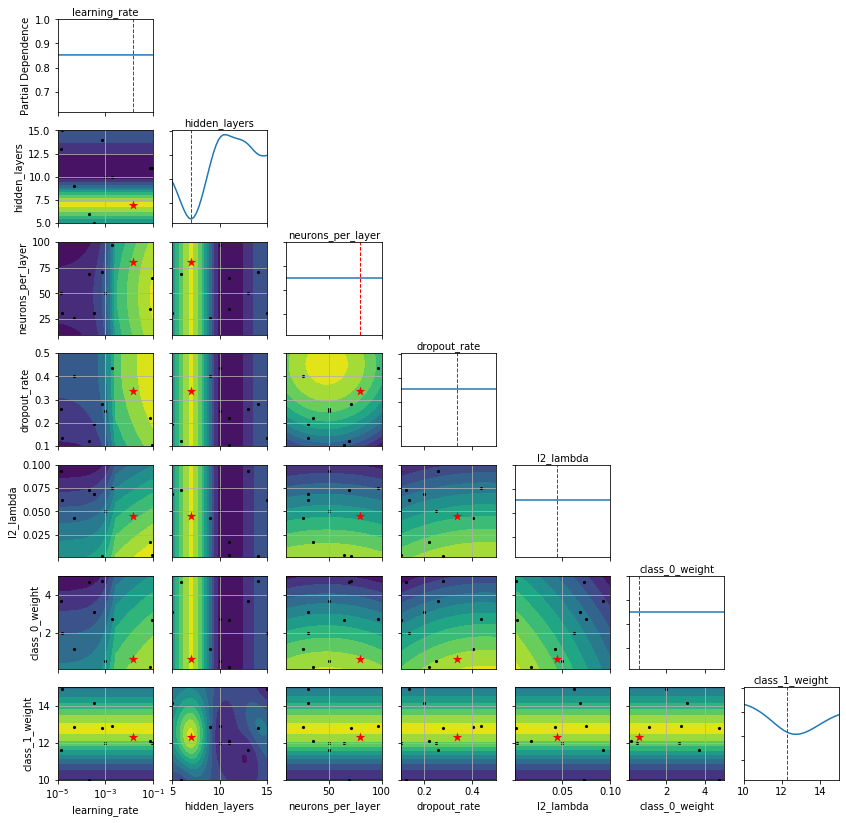

In [19]:
fig, ax = plot_objective(result=search_result, dimension_names=dim_names)

In [20]:
space = search_result.space
winning_hyperparams = space.point_to_dict(search_result.x)
winning_hyperparams

{'learning_rate': 0.01535224694197351,
 'hidden_layers': 7,
 'neurons_per_layer': 80,
 'dropout_rate': 0.33874006317859484,
 'l2_lambda': 0.04513744253250554,
 'class_0_weight': 0.5898770875082143,
 'class_1_weight': 12.296244459829335}

In [21]:
# 0.001, 2, 30, 0.5, 0.1, 0.5, 15 defaults

In [78]:
learning_rate = winning_hyperparams['learning_rate'] / 10
learning_rate = 0.001
hidden_layers = winning_hyperparams['hidden_layers']
units_per_layer = winning_hyperparams['neurons_per_layer']
dropout_rate = winning_hyperparams['dropout_rate']
l2_lambda = winning_hyperparams['l2_lambda']
#l2_lambda = 0.05
class_0_weight = winning_hyperparams['class_0_weight']
#class_0_weight = 0.6
class_1_weight = winning_hyperparams['class_1_weight']

initial_bias = np.log([ignition_count/no_ignition_count])
output_bias = tf.keras.initializers.Constant(initial_bias)
    
class_weight = {0: class_0_weight, 1: class_1_weight}

EPOCHS = 100
BATCH_SIZE = 100000
STEPS_PER_EPOCH = (len(training_data) * 1) // BATCH_SIZE
VALIDATION_STEPS = (len(validation_data) * 1) // BATCH_SIZE

In [79]:
# Define the keras model
model = keras.Sequential()

# Add input layer
model.add(keras.layers.Dense(
    units_per_layer, 
    activation = 'relu', 
    input_dim = train_features.shape[-1],
))

# Add fully connected hidden layers
for i in range(hidden_layers):
    model.add(keras.layers.Dense(
        units_per_layer,
        bias_initializer=keras.initializers.VarianceScaling(
            scale=1.0,
            mode='fan_in', 
            distribution='normal', 
            seed=None
        ),
        kernel_regularizer=keras.regularizers.l2(l2_lambda),
        activation = 'relu')
    )

# Add dropout layer
model.add(keras.layers.Dropout(dropout_rate))

# Add output layer
model.add(keras.layers.Dense(
    1, 
    activation = 'sigmoid', 
    bias_initializer = output_bias
))

model.compile(
    optimizer=keras.optimizers.Adam(lr=learning_rate),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics
)

In [ ]:
history = model.fit(
    train_features,
    train_labels,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    validation_steps=VALIDATION_STEPS,
    class_weight=class_weight,
    workers=8
)

model.save('../trained_models/best_MLP.keras')

Train on 449258 samples, validate on 449257 samples
Epoch 1/100
349258/449258 [======================>.......] - ETA: 0s - loss: 8.5828 - tp: 7005.0000 - fp: 59698.0000 - tn: 276834.0000 - fn: 5721.0000 - accuracy: 0.8127 - precision: 0.1050 - recall: 0.5504 - auc: 0.7787 - f1: 0.1768 - val_loss: 7.3175 - val_tp: 9169.0000 - val_fp: 71037.0000 - val_tn: 314308.0000 - val_fn: 5486.0000 - val_accuracy: 0.8087 - val_precision: 0.1143 - val_recall: 0.6257 - val_auc: 0.8140 - val_f1: 0.1933Epoch 19/100


400000/449258 [=========================>....] - ETA: 0s - loss: 2.7062 - tp: 9226.0000 - fp: 63973.0000 - tn: 321349.0000 - fn: 5452.0000 - accuracy: 0.8264 - precision: 0.1260 - recall: 0.6286 - auc: 0.8243 - f1: 0.2100 - val_loss: 2.3006 - val_tp: 9846.0000 - val_fp: 63492.0000 - val_tn: 321853.0000 - val_fn: 4809.0000 - val_accuracy: 0.8292 - val_precision: 0.1343 - val_recall: 0.6719 - val_auc: 0.8486 - val_f1: 0.2238Epoch 37/100


349258/449258 [======================>.......] - ETA: 1s - loss: 1.1361 - tp: 8307.0000 - fp: 55734.0000 - tn: 280787.0000 - fn: 4430.0000 - accuracy: 0.8277 - precision: 0.1297 - recall: 0.6522 - auc: 0.8360 - f1: 0.2167 - val_loss: 0.9732 - val_tp: 9884.0000 - val_fp: 60062.0000 - val_tn: 325283.0000 - val_fn: 4771.0000 - val_accuracy: 0.8379 - val_precision: 0.1413 - val_recall: 0.6744 - val_auc: 0.8551 - val_f1: 0.2337Epoch 55/100


349258/449258 [======================>.......] - ETA: 1s - loss: 0.7829 - tp: 8419.0000 - fp: 56499.0000 - tn: 280015.0000 - fn: 4325.0000 - accuracy: 0.8258 - precision: 0.1297 - recall: 0.6606 - auc: 0.8393 - f1: 0.2170 - val_loss: 0.6751 - val_tp: 10201.0000 - val_fp: 62915.0000 - val_tn: 322430.0000 - val_fn: 4454.0000 - val_accuracy: 0.8316 - val_precision: 0.1395 - val_recall: 0.6961 - val_auc: 0.8581 - val_f1: 0.2324Epoch 73/100


349258/449258 [======================>.......] - ETA: 1s - loss: 0.7096 - tp: 8695.0000 - fp: 57609.0000 - tn: 278801.0000 - fn: 4153.0000 - accuracy: 0.8232 - precision: 0.1311 - recall: 0.6768 - auc: 0.8438 - f1: 0.2191 - val_loss: 0.6120 - val_tp: 10328.0000 - val_fp: 63494.0000 - val_tn: 321851.0000 - val_fn: 4327.0000 - val_accuracy: 0.8304 - val_precision: 0.1399 - val_recall: 0.7047 - val_auc: 0.8604 - val_f1: 0.2335Epoch 91/100


149258/449258 [========>.....................] - ETA: 2s - loss: 0.7021 - tp: 3811.0000 - fp: 23710.0000 - tn: 119917.0000 - fn: 1820.0000 - accuracy: 0.8290 - precision: 0.1385 - recall: 0.6768 - auc: 0.8475 - f1: 0.2306

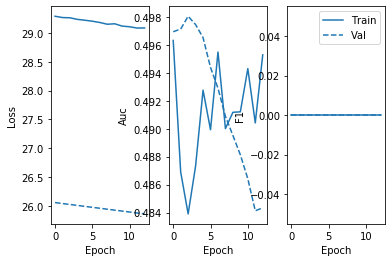

In [74]:
plot_metrics(history)

loss :  1.3272638025220087
tp :  10601.0
fp :  68472.0
tn :  364558.0
fn :  5627.0
accuracy :  0.8350636
precision :  0.13406599
recall :  0.6532536
auc :  0.8440364
f1 :  0.22308461
No fire (True Negatives):  364558
False alarms (False Positives):  68472
Fires missed (False Negatives):  5627
Fires detected (True Positives):  10601
Total fires:  16228


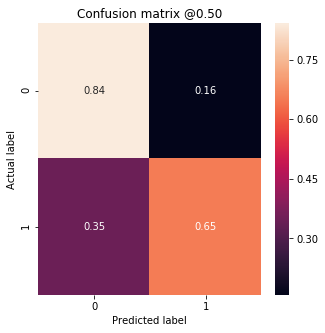

In [26]:
train_predictions = model.predict(train_features, batch_size=len(train_features))

results = model.evaluate(
    test_features,
    test_labels,
    batch_size=BATCH_SIZE, 
    verbose=0
)

for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)

plot_cm(test_labels, test_predictions)

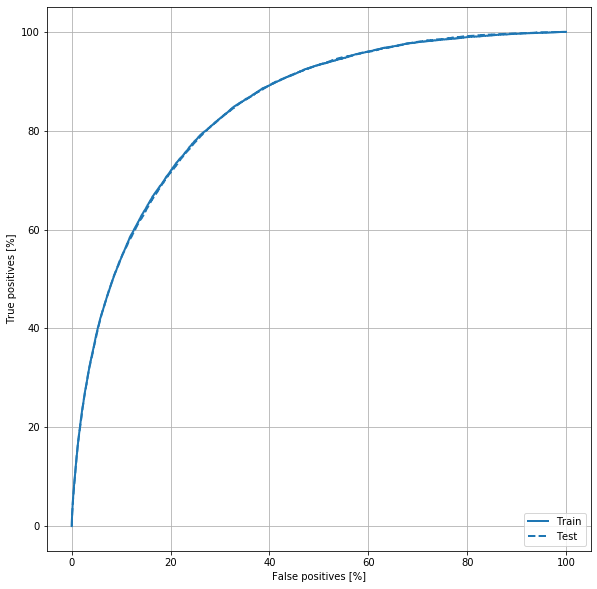

In [27]:
plot_roc("Train", train_labels, train_predictions, color=colors[0])
plot_roc("Test", test_labels, test_predictions, color=colors[0], linestyle='--')

plt.legend(loc='lower right')

plt.show()

In [62]:
# Load test data
test = pd.read_csv(test_file, dtype=dtypes)

# Get feature columns of intrest
test_data = test[features]

# One hot encode month
month = np.array(test_data['weather_bin_month']).reshape(-1, 1)
onehot_month = onehot_encoder.fit_transform(month)

test_data.drop('weather_bin_month', axis=1, inplace=True)
onehot_month_df = pd.DataFrame(onehot_month, columns=column_names)
test_data = pd.concat([test_data, onehot_month_df], axis=1)

/home/siderealyear/anaconda3/envs/wildfire/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,lat,lon,veg,ignition,mean.air.2m,mean.apcp,mean.rhum.2m,mean.dpt.2m,mean.pres.sfc,mean.uwnd.10m,...,March,April,May,June,July,August,Septermber,October,November,December
46,40.10525,-121.9699,43.2,1.0,303.005414,0.000022,9.274757,265.515986,94267.699344,-0.703275,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
50,38.90858,-120.1582,55.0,1.0,286.187027,0.000654,34.807229,270.509356,79975.476172,3.055130,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
56,39.03347,-121.3140,39.3,1.0,304.525894,0.000000,16.320005,273.587448,98771.233172,-2.332060,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
105,41.61649,-123.5675,79.1,1.0,284.943720,0.000035,63.690901,277.807208,90718.230609,-2.044807,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
125,33.90706,-116.3568,7.8,1.0,290.655068,0.002747,24.191231,269.144092,90399.880500,6.297434,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
# Pick one spatial bin with fires
test_data = test_data[(test_data['lat'] == 38.90858) & (test_data['lon'] == -120.1582)]

,lat,lon,veg,ignition,mean.air.2m,mean.apcp,mean.rhum.2m,mean.dpt.2m,mean.pres.sfc,mean.uwnd.10m,...,March,April,May,June,July,August,Septermber,October,November,December
50,38.90858,-120.1582,55.0,1.0,286.187027,0.000654,34.807229,270.509356,79975.476172,3.055130,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
55,38.90858,-120.1582,55.1,0.0,264.714497,0.568509,85.654468,262.662417,78747.766266,0.187434,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
782,38.90858,-120.1582,55.1,0.0,284.565336,0.000084,31.335444,267.916497,80434.650672,-1.069051,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
802,38.90858,-120.1582,55.0,0.0,272.976090,0.346300,48.041214,262.760848,79097.916016,1.580590,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1407,38.90858,-120.1582,55.1,0.0,282.063608,0.005662,35.982473,267.566055,80051.567750,2.285130,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
# Split into features and label as numpy arrays
test_labels = np.array(test_data.pop('ignition'))
test_features = np.array(test_data)

# Scale
test_features = scaler.transform(test_features)

In [65]:
# Predict
test_predictions = model.predict(test_features, batch_size=len(test_features))

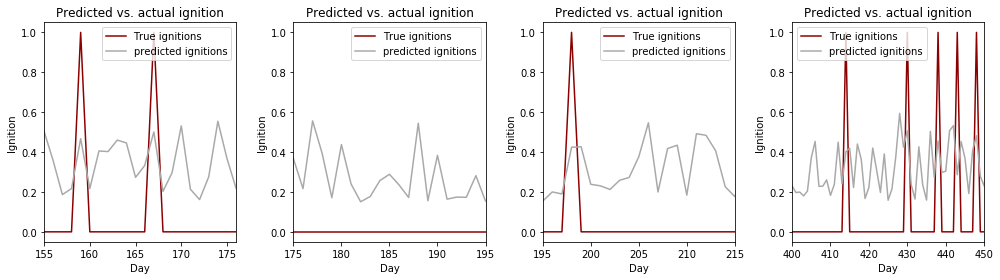

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplots(1,4,figsize=(14,4))

plt.subplot(1, 4, 1)

plt.plot(
    range(len(test_labels)), 
    test_labels,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(test_labels)), 
    test_predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(155,176)

plt.subplot(1, 4, 2)

plt.plot(
    range(len(test_labels)), 
    test_labels,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(test_labels)), 
    test_predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(175,195)

plt.subplot(1, 4, 3)

plt.plot(
    range(len(test_labels)), 
    test_labels,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(test_labels)), 
    test_predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(195,215)

plt.subplot(1, 4, 4)

plt.plot(
    range(len(test_labels)), 
    test_labels,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(test_labels)), 
    test_predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(400,(450))

plt.tight_layout()
plt.show()